In [1]:
# 初始化
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from IPython.display import display,HTML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

In [3]:
(untar_data(URLs.IMDB)/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/labeledBow.feat'),Path('/root/.fastai/data/imdb/train/pos')]

In [4]:
# 这与上面的代码将得到一样的结果
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

In [5]:
# 转换
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

In [6]:
# 分词(tokenize)
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#160) ['xxbos','xxmaj','this','film','probably','would','have','been','good',','...]

In [7]:
# 数值化(numericalize)
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

TensorText([  2,   8,  20,  33, 228,  67,  39, 102,  72,  11])

In [8]:
# Numericalize.decode 会给我们返回字符串标记
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','xxmaj','this','film','probably','would','have','been','good',',']

In [9]:
# Tokenizer.decode 将这些内容转换回一个字符串
tok.decode(nums_dec)

'xxbos xxmaj this film probably would have been good ,'

In [10]:
tok((txts[0], txts[1]))

((#160) ['xxbos','xxmaj','this','film','probably','would','have','been','good',','...],
 (#631) ['xxbos','xxup','warning',':','xxup','may','xxup','contain','xxup','spoilers'...])

In [11]:
# 编写自己的转换
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

In [12]:
@Transform
def f(x:int): return x+1
f(2),f(3.0)

(3, 3.0)

In [13]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

In [14]:
# 注意实现时是setups, 调用时是setup
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z # 3, -1, 2

(3.0, -1.0, 2.0)

In [15]:
# 管道
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,   20,   33,  228,   67,   39,  102,   72,   11,   59,   42,   83,   32,  353,    7, 1021,   38, 1290, 4102])

In [16]:
tfms.decode(t)[:100]

"xxbos xxmaj this film probably would have been good , if they did n't use xxup cgi ( computer genera"

In [17]:
# TfmdLists
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

In [18]:
t = tls[0]; t[:20]

TensorText([   2,    8,   20,   32,  263,   74,   42,   99,   68,   11,   63,   47,   89,   36,  380,    7, 1522,   37, 1290, 4900])

In [19]:
tls.decode(t)[:100]

"xxbos xxmaj this film probably would have been good , if they did n't use xxup cgi ( computer genera"

In [20]:
tls.show(t)

xxbos xxmaj this film probably would have been good , if they did n't use xxup cgi ( computer generated xxunk the werewolf xxunk made the creatures look fake and the werewolves looked xxunk is great for certain effects like the xxunk in xxmaj jurassic xxmaj park or xxunk when we see a film where the creature must look completely real , cgi is not the way to xxunk at xxmaj an xxmaj american xxmaj werewolf in xxunk xxunk makeup and a mechanical creature and what you come up with was more realistic than what was shown in the xxunk film did offer a few gags that was fun to watch and the humor in this movie seemed to have drawn me in but it 's nothing more than a film that i thought was xxunk that 's not good xxunk my opinion , an xxmaj american xxmaj werewolf in xxmaj paris does n't hold up to the original .


In [21]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize],
                splits=splits)

In [22]:
tls.valid[0][:20]

TensorText([    2,     8,     9,   632,   797,    28,   944,     9,  2067,    15,   457,   646,   175,    10,     8,     9, 10214,    16,  3599,   278])

In [23]:
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

In [24]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

(['neg', 'pos'], TensorCategory(0))

In [25]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

In [26]:
# 数据集
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(TensorText([   2,    8,   20,   32,  263,   74,   42,   99,   68,   11,   63,   47,   89,   36,  380,    7, 1522,   37, 1290, 4900]),
 TensorCategory(0))

In [27]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(TensorText([    2,     8,     9,   632,   797,    28,   944,     9,  2067,    15,   457,   646,   175,    10,     8,     9, 10214,    16,  3599,   278]),
 TensorCategory(1))

In [28]:
# 一个计算机视觉的例子
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [29]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2),
                          title=same_breed, ctx=ctx)

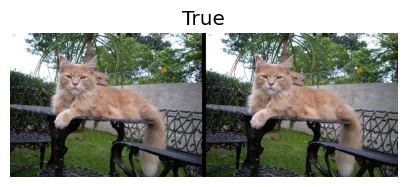

In [30]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

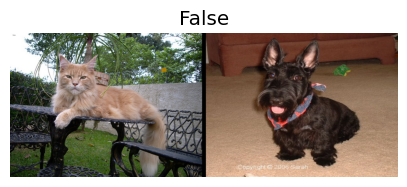

In [33]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

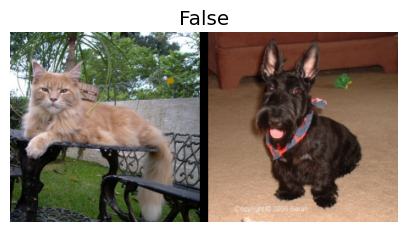

In [34]:
s2 = Resize(224)(s1)
s2.show();

In [35]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

In [36]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l)
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}

    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)

    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same:
            cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]),same

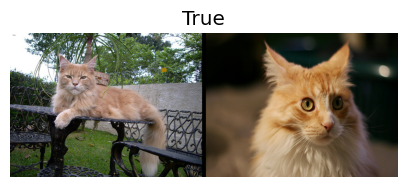

In [37]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

In [39]:
label_func(files[1])

'scottish_terrier'

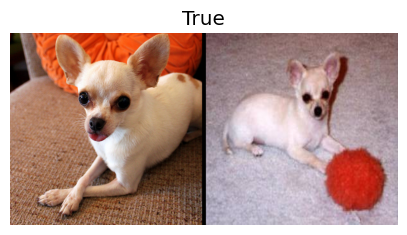

In [40]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

In [41]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])